In [ ]:
!pip install d2l==1.0.0-alpha0
#!pip install d2l==0.17.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 955 kB/s 


In [ ]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn  
from d2l import torch as d2l

# 13.1 Image Augmentation(이미지 증강)

- train image의 랜덤한 변환을 통해 training set의 수를 늘리는 방법

ex) 이미지를 다양한 방법으로 뒤집거나 자르거나 밝기, 색상 등을 조정함.
- Image Augmentation을 하는 이유 : 심층신경망은 일반적으로 대량의 훈련 데이터가 있어야만 비교적 이상적인 결과를 얻을 수 있다. 만약 데이터 양이 제한된 경우에는 Image Augmentation을 통해 training set의 다양성을 높이고 모델의 일반화 능력을 높여 과적합을 피할 수 있기 때문.

## 13.1.1 Common Image Augmentation Methods

주어진 $400\times 500$ 사진을 example로 사용.


In [ ]:
import urllib.request
url = "https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/cat1.jpg"
urllib.request.urlretrieve(url, '/content/sample_data/cat1.jpg')

('/content/sample_data/cat1.jpg', <http.client.HTTPMessage at 0x7f09407caf50>)

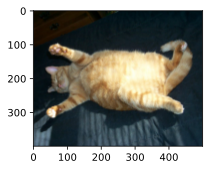

In [ ]:
d2l.set_figsize()
img = d2l.Image.open('/content/sample_data/cat1.jpg')
d2l.plt.imshow(img);

In [ ]:
#입력 이미지 img에 대해 image augmentation 방법인 aug를 여러 번 실행하고 그에 따른 결과를 표시하는 함수
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5): 
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

### Flipping and Cropping


[**Flipping the image left and right**] usually does not change the category of the object. 
This is one of the earliest and most widely used methods of image augmentation.
Next, we use the `transforms` module to create the `RandomHorizontalFlip` instance, which flips
an image left and right with a 50% chance.


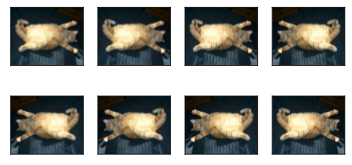

In [ ]:
apply(img, torchvision.transforms.RandomHorizontalFlip()) #이미지를 50% 확률로 좌우로 뒤집음.

[**Flipping up and down**] is not as common as flipping left and right. But at least for this example image, flipping up and down does not hinder recognition.
Next, we create a `RandomVerticalFlip` instance to flip
an image up and down with a 50% chance.


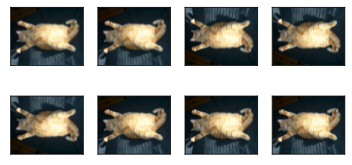

In [ ]:
apply(img, torchvision.transforms.RandomVerticalFlip()) #이미지를 50% 확률로 상하로 뒤집음.

In the code below, we [**randomly crop**] an area with an area of $10\% \sim 100\%$ of the original area each time, and the ratio of width to height of this area is randomly selected from $0.5 \sim 2$. Then, the width and height of the region are both scaled to 200 pixels. 
Unless otherwise specified, the random number between $a$ and $b$ in this section refers to a continuous value obtained by random and uniform sampling from the interval $[a, b]$.


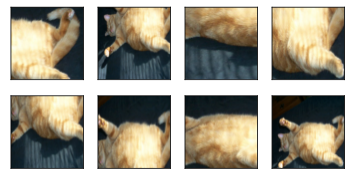

In [ ]:
#이미지를 원래 이미지의 10%~100% 크기로 무작위로 자른 후 200픽셀로 크기 확대
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

### Changing Colors (밝기, 대비, 채도, 색조)

Another augmentation method is changing colors. We can change four aspects of the image color: brightness, contrast, saturation, and hue. In the example below, we [**randomly change the brightness**] of the image to a value between 50% ($1-0.5$) and 150% ($1+0.5$) of the original image.


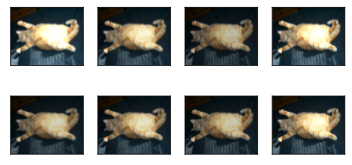

In [ ]:
#밝기를 원본의 50%~150% 사이의 값으로 무작위 변경
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0)) 

Similarly, we can [**randomly change the hue**] of the image.


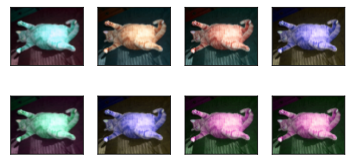

In [ ]:
#색조(hue)를 무작위 변경
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

We can also create a `RandomColorJitter` instance and set how to [**randomly change the `brightness`, `contrast`, `saturation`, and `hue` of the image at the same time**].


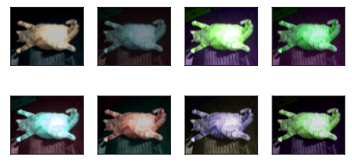

In [ ]:
#무작위로 밝기, 대비, 채도, 색조를 동시에 변경
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

### Combining Multiple Image Augmentation Methods

In practice, we will [**combine multiple image augmentation methods**]. 
For example,
we can combine the different image augmentation methods defined above and apply them to each image via a `Compose` instance.


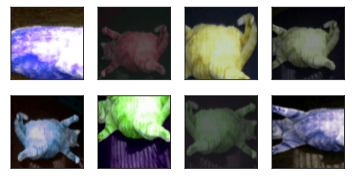

In [ ]:
#위의 여러 방법들을 결합(동시에 사용)
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug]) #이미지를 50% 확률로 좌우로 뒤집음 + 색조 무작위 변경 + 이미지를 무작위로 자르고 확대
apply(img, augs)

## [**Training with Image Augmentation**]

- image augmentation를 이용해 모델을 train.
- training dataset으로 CIFAR-10을 사용하여 ResNet-18 model을 훈련


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data


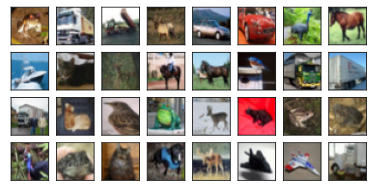

In [ ]:
#CIFAR-10 dataset의 처음 train image 32장
all_images = torchvision.datasets.CIFAR10(train=True, 
                                          root="../data", #저장 위치
                                          download=True #다운로드 여부
                                          ) 
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

* **예측 과정에서 정확한 결과를 얻기 위해 train image에만 image augmentation 적용.**
* `ToTensor`()를 하는 이유는 `torchvision`이 PIL Image 형태로만 입력을 받기 때문에 데이터 처리를 위해서 Tensor형으로 변환 필요

In [ ]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(), #무작위 좌우 뒤집기
     torchvision.transforms.ToTensor()]) #ToTensor 형식으로 변환

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()]) #ToTensor 형식으로 변환

[CIFAR10 dataset에 image augmentation 방법(augs)을 적용하는 보조 함수 정의]


In [ ]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10( #CIFAR10 dataset을 가져옴
        root="../data", #데이터 저장위치
        train=is_train, #True: train set, False: test set
        transform=augs, 
        download=True 
        ) 
    dataloader = torch.utils.data.DataLoader( #torchvision.dataset의 데이터 불러옴
        dataset, 
        batch_size=batch_size, 
        shuffle=is_train, #True이면 epoch별로 데이터셋 뒤섞음
        num_workers=d2l.get_dataloader_workers()
        )
    return dataloader

### Multi-GPU Training


[Multi-GPU를 사용하여 모델을 학습하고 평가하는 함수 정의] 


In [ ]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """Train for a minibatch with mutiple GPUs (defined in Chapter 13)."""
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad() #gradient 초기화
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [ ]:
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """Train a model with mutiple GPUs (defined in Chapter 13)."""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc']) #그래프
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices) # Perform multi-GPU training for a single minibatch
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

* [`train_with_data_aug` 정의] : 사용 가능한 모든 GPU를 가져와서, train dataset에 image augmentation를 적용하고, Adam을 최적화 알고리즘으로 사용하여,  위에서 정의한 `train_ch13` 함수를 호출하여 모델을 훈련시키고 평가하는 함수

In [ ]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)
net.apply(d2l.init_cnn)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    net(next(iter(train_iter))[0])
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


[무작위 좌우 뒤집기(image augmentation)를 사용해 ResNet-18 model 학습] 


loss 0.218, train acc 0.924, test acc 0.809
1148.8 examples/sec on [device(type='cuda', index=0)]


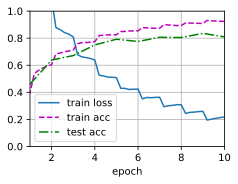

In [ ]:
train_with_data_aug(train_augs, test_augs, net) #시간 오래 걸림

## Summary

* Image augmentation는 training data를 기반으로 무작위 이미지를 생성하여 그 수를 늘림으로써 모델의 일반화 능력을 향상시키는 방법이다.
* 예측 과정에서 정확한 결과를 얻기 위해 일반적으로 training data에만 image augmentation을 적용한다.
* 딥러닝 프레임워크에는 동시에 적용할 수 있는 다양한 Image augmentation 방법이 있다.


## Exercises

1. Train the model without using image augmentation: `train_with_data_aug(test_augs, test_augs)`. Compare training and testing accuracy when using and not using image augmentation. Can this comparative experiment support the argument that image augmentation can mitigate overfitting? Why?
1. Combine multiple different image augmentation methods in model training on the CIFAR-10 dataset. Does it improve test accuracy? 
1. Refer to the online documentation of the deep learning framework. What other image augmentation methods does it also provide?


#13.2 Fine-Tuning(미세 조정)

- 전이 학습의 대표적인 기법
- **전이학습(Transfer Learning)** : 기존에 다른 데이터로 학습된 모델을 가져다 새로운 데이터에 맞게 모델을 변형시키는 방법

(예시 상황) 다양한 유형의 의자 이미지를 학습한 뒤 이를 바탕으로 사용자에게 구매 링크를 추천하는 모델을 만들려고 함. 이때 100개의 의자를 1000개의 다른 각도로 각각 촬영한 다음 이 데이터로 분류 모델을 학습하는 경우

1.   만일 ImageNet에 적합한 모델을 사용한다면, ImageNet의 데이터 수(약 천만개 이상)보다 한참 적기 때문에 과적합 위험.
2.   더 많은 데이터 수집 : 많은 시간과 비용 지출.

> => Fine-Tuning(기존에 학습이 된 모델의 레이어에 새로운 데이터를 추가로 학습시켜서 파라미터를 업데이트하는 방식으로 모델을 변형시키는 방법)



## Steps


1. source dataset(ImageNet)으로 기존의 모델(*source model*)을 사전에 훈련.
2. *source model*의 출력층을 제외하고 모델의 모든 구조와 parameter를 복사해 새로운 신경망 모델(*target model*) 생성
3. *target model*에 출력층 추가 : 'output의 개수 = target dataset의 범주 수'로 설정한 후 parameter 초기화
4. target dataset로 *target model*을 학습 : *target model*의 출력층은 처음부터 학습되고, 나머지 층의 parameter은 source model의 parameter에 따라 fine-tuning됨.
* *target model*의 첫 번째 층은 *source model*의 "일반적인(general)" 특징을 추출하도록 하는 학습이 이루어지는 반면에, 출력층에 가까울수록 target dataset에서 나타날 수 있는 "구체적인(specific)"특징을 추출하도록 학습이 이루어진다. 

![Fine tuning.](http://d2l.ai/_images/finetune.svg)




* 이처럼 target dataset이 source dataset보다 한참 적을 경우, fine-tuning을 통해 모델의 일반화 능력을 향상시킨다.
> 학습 데이터의 수가 적을 경우, fine-tuning을 통해 성능이 좋은 모델의 능력을 이용함으로써 빠른 학습 속도와 높은 정확도를 얻을 수 있음

## Hot Dog Recognition

* 핫도그가 없는 수천개의 사진으로 구성된 데이터셋(*source dataset*)으로 사전학습된 ResNet model(: *source model*)을 fine-tuning하여 *target model*을 만들어 핫도그 사진을 인식

### Reading the Dataset

핫도그가 있는 positive-class images 1400장과 핫도그가 없는 negative-class images 1000장으로 구성.

In [ ]:
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

In [ ]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

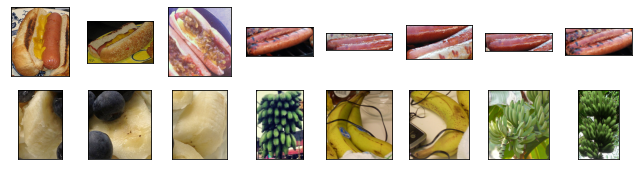

In [ ]:
hotdogs = [train_imgs[i][0] for i in range(8)] #핫도그가 있는 positive-class images 8장
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)] #핫도그가 없는 negative-class images 8장
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

In [ ]:
#이미지의 색과 크기가 다양하기 때문에 데이터셋 색과 크기 조정(torchvision.transforms.Compose) + 이미지 증강
#RGB색 채널 표준화
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

#train : 중앙의 224x224 영역을 잘라냄 -> 무작위로 좌우 뒤집기
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(), 
    normalize]) 

#test : 높이와 너비를 256픽셀로 조정한 후 중앙의 224x224 영역을 잘라냄
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

### [**Defining and Initializing the Model**]

In [ ]:
# 사전학습한 모델(ResNet-18 : source model)의 파라미터를 다운로드
# 다운로드 전 인터넷 연결 필수!
pretrained_net = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
finetune_net = torchvision.models.resnet18(pretrained=True) #source model에서 모든 parameter를 복사(다운로드)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2) #Target model의 출력층 정의 (target dataset의 범주 수 = 2 = output sample size)
nn.init.xavier_uniform_(finetune_net.fc.weight); #Target model의 출력층 parameter 초기화 

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### [**Fine-Tuning the Model**]

`train_fine_tuning` 함수 정의 : fine-tuning을 사용해 모델을 훈련하는 함수 

In [ ]:
# If `param_group=True`, the model parameters in the output layer will be
# updated using a learning rate ten times greater
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs), #train_augs 방식으로 train dataset 변형 
        batch_size=batch_size, shuffle=True) 
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs),  #test_augs 방식으로 train dataset 변형 
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none") #다중분류를 위한 손실함수
    if param_group:
        params_1x = [param for name, param in net.named_parameters() #net 내 parameter 값 반환
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

* source model의 parameter를 fine-tuning할 때에 **학습률을 (비교적) 작은 값으로 설정**
* 이유 : 학습률이 비교적 클 경우, 이전 모델(source model)의 일반적인(general) 특징들이 사라져 새로운 데이터(target dataset)에 overfitting 될 위험이 존재하기 때문.

loss 0.337, train acc 0.894, test acc 0.924
298.0 examples/sec on [device(type='cuda', index=0)]


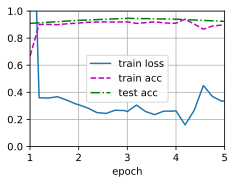

In [ ]:
train_fine_tuning(finetune_net, 5e-5)

[비교] 동일한 모델이지만 전체 모델을 처음부터 학습하는 경우 [조금 더 큰 학습률]

loss 0.356, train acc 0.840, test acc 0.795
368.0 examples/sec on [device(type='cuda', index=0)]


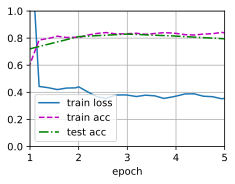

In [ ]:
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

* 결론 : fine-tuning한 모델이 같은 epoch에서 더 나은 결과를 보임.

## Summary

* 전이학습은 기존에 다른 데이터로 학습된 모델을 가져다 새로운 데이터에 맞게 모델을 변형시키는 방법이고, 대표적인 기법이 Fine-Tuning이다.
* Target model은 source model에서 출력층의 것을 제외한 모든 parameter를 복사한 후 target dataset를 바탕으로 fine-tuning을 한다. 반면에, target model의 출력층은 처음부터 학습해야 한다. 
* Fine-tuning을 할 때에는 처음부터 훈련할 때보다 작은 학습률을 사용한다.


## Exercises

1. Keep increasing the learning rate of `finetune_net`. How does the accuracy of the model change?
2. Further adjust hyperparameters of `finetune_net` and `scratch_net` in the comparative experiment. Do they still differ in accuracy?
3. Set the parameters before the output layer of `finetune_net` to those of the source model and do *not* update them during training. How does the accuracy of the model change? You can use the following code.

# 13.3 Object Detection and Bounding Boxes

- *object detection* : 이미지에 여러 객체가 있는 경우 해당 객체의 범주와 구체적 위치까지 파악


<img src = "https://drive.google.com/uc?id=1fxFwmxePY3SL2Yut0BmOX3vQnnCrdzHe" height = 400 width = 596>

In [ ]:
import urllib.request
url2 = "https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/catdog.jpg"
urllib.request.urlretrieve(url2, '/content/sample_data/catdog.jpg')

('/content/sample_data/catdog.jpg',
 <http.client.HTTPMessage at 0x7faa94527210>)

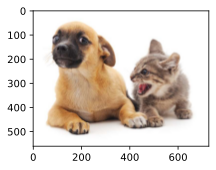

In [ ]:
d2l.set_figsize()
img = d2l.Image.open('/content/sample_data/catdog.jpg')
d2l.plt.imshow(img);

## Bounding Boxes

: object detection에서 객체의 특정 위치를 표시.
- 표현 방법
1. 상자 왼쪽 위 모서리의 $(x, y)$축 좌표, 오른쪽 아래 모서리의 $(x, y)$축 좌표
2. 상자 중심의 $(x, y)$축 좌표, 상자의 높이와 너비

In [ ]:
#boxes : 2차원 텐서 (n, 4) / n = 상자의 수
def box_corner_to_center(boxes): #1번째 표현 방법 => 2번째 표현 방법 변환
    """Convert from (upper-left, lower-right) to (center, width, height)."""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes): #2번째 표현 방법 => 1번째 표현 방법 변환
    """Convert from (center, width, height) to (upper-left, lower-right)."""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

개와 고양이의 Bounding Boxes 정의

In [ ]:
# Here `bbox` is the abbreviation for bounding box
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0] #상자 왼쪽 위 모서리의 (x,y) 축 좌표, 오른쪽 아래 모서리의 (x,y) 축 좌표 지정

In [ ]:
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

In [ ]:
def bbox_to_rect(bbox, color): #상자 시각화
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

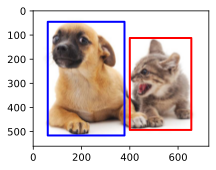

In [ ]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));